In [1]:
%matplotlib inline

from collections import defaultdict

import random as rn
import copy as copy

import time

import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

In [10]:
df = pd.read_csv('imbd_cleaned.csv')

# Mappa di raggruppamento
category_mapping = {
    'movie': 'Film',
    'tvMovie': 'Film',
    'short': 'Shorts',
    'tvShort': 'Shorts',
    'tvSeries': 'Serie TV',
    'tvMiniSeries': 'Serie TV',
    'tvEpisode': 'Serie TV',
    'tvSpecial': 'Speciale TV',
    'video': 'Video',
    'videoGame': 'Videogame'
}

# Applicare la mappa al dataframe
df['titleType'] = df['titleType'].map(category_mapping)

X = df.select_dtypes(include=['number'])
features_name = X.columns
X = X.values
y = np.array(df['titleType'])

In [25]:
features_name

Index(['startYear', 'runtimeMinutes', 'awardWins', 'numVotes', 'totalImages',
       'totalVideos', 'totalCredits', 'criticReviewsTotal', 'AwNmExWins',
       'canHaveEpisodes', 'isAdult', 'numRegions', 'userReviewsTotal',
       'castNumber', 'companiesNumber', 'averageRating', 'externalLinks',
       'writerCredits', 'directorsCredits', 'quotesTotal'],
      dtype='object')

In [22]:
df['titleType'].unique()

array(['Shorts', 'Film', 'Serie TV', 'Speciale TV', 'Video', 'Videogame'],
      dtype=object)

## Data Partitioning

In [11]:
from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100, stratify=y)

In [13]:
from sklearn.preprocessing import StandardScaler

In [14]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [15]:
from sklearn.preprocessing import LabelEncoder

# Se non l'hai già fatto
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

In [16]:
from xgboost import XGBClassifier

In [17]:

# Definisci il modello con i migliori iperparametri trovati
best_model = XGBClassifier(
    objective='binary:logistic',
    tree_method='exact',
    random_state=42,
    subsample=0.8,
    reg_lambda=10,
    reg_alpha=1,
    n_estimators=300,
    max_depth=7,
    learning_rate=0.1,
    gamma=0,
    colsample_bytree=0.8, probability=True
)

# Addestra il modello con i dati di addestramento
best_model.fit(X_train, y_train)

# evals_result = best_model.evals_result()
# epochs = len(evals_result['validation_0']['logloss'])
# print("Numero medio di epoch del miglior modello:", epochs)

C:\Users\alban\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [00:13:42] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "probability" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=0, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=300,
              n_jobs=None, num_parallel_tree=None, ...)

In [24]:
# Supponendo che y_pred e y_test_numeric siano già definiti
y_pred = best_model.predict(X_test)

# Definire gli intervalli
intervals = ['Film', 'Serie TV', 'Shorts', 'Speciale TV', 'Video', 'Videogame']

# Stampare l'accuratezza
print('Accuracy %s' % accuracy_score(y_test, y_pred))

# Stampare il F1-score
print('F1-score %s' % f1_score(y_test, y_pred, average=None))

print(classification_report(y_test, y_pred, target_names=intervals))

Accuracy 0.9378980891719745
F1-score [0.929948   0.97424875 0.91007477 0.32911392 0.58519108 0.8297456 ]
              precision    recall  f1-score   support

        Film       0.91      0.95      0.93     12835
    Serie TV       0.97      0.98      0.97     24351
      Shorts       0.89      0.93      0.91      4992
 Speciale TV       0.60      0.23      0.33       343
       Video       0.76      0.48      0.59      1541
   Videogame       0.85      0.81      0.83       526

    accuracy                           0.94     44588
   macro avg       0.83      0.73      0.76     44588
weighted avg       0.93      0.94      0.93     44588



In [26]:
# Output grezzo da XGBoost
importance_raw = best_model.get_booster().get_score(importance_type='gain')

# Rinomina le chiavi con i nomi veri
importance_named = {
    features_name[int(k[1:])]: v
    for k, v in importance_raw.items()
}
# Ordina le caratteristiche in base all'importanza
importance_sorted = sorted(importance_named.items(), key=lambda x: x[1], reverse=True)
# Estrai i nomi delle caratteristiche e i valori di importanza
features, importance_values = zip(*importance_sorted)
#stampare l'importanza delle caratteristiche
print("Importanza delle caratteristiche:")
for feature, importance in importance_sorted:
    print(f"{feature}: {importance:.4f}")

Importanza delle caratteristiche:
canHaveEpisodes: 41.2576
isAdult: 33.9527
runtimeMinutes: 33.7037
numRegions: 28.0183
directorsCredits: 17.0973
awardWins: 9.0808
AwNmExWins: 5.3239
castNumber: 5.1537
startYear: 4.6193
writerCredits: 4.0854
totalCredits: 3.6029
quotesTotal: 3.3312
companiesNumber: 2.9963
externalLinks: 2.6385
totalVideos: 2.3437
totalImages: 1.9721
averageRating: 1.8971
userReviewsTotal: 1.6300
criticReviewsTotal: 1.2905
numVotes: 1.2325


In [27]:
import shap
shap.initjs()

C:\Users\alban\AppData\Roaming\Python\Python313\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [28]:
fitted_bm = best_model.fit(X_train, y_train)

C:\Users\alban\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [00:20:37] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "probability" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [29]:
shap_explainer = shap.TreeExplainer(fitted_bm)
shap_vals = shap_explainer.shap_values(X_test)

In [30]:
# Ricostruisci X_test come DataFrame
X_test_df = pd.DataFrame(X_test, columns=features_name)

In [31]:
# shap_vals ha shape (n_samples, n_features, n_classes)
# Lo convertiamo in lista di array 2D
shap_vals_per_class = [shap_vals[:, :, i] for i in range(shap_vals.shape[2])]


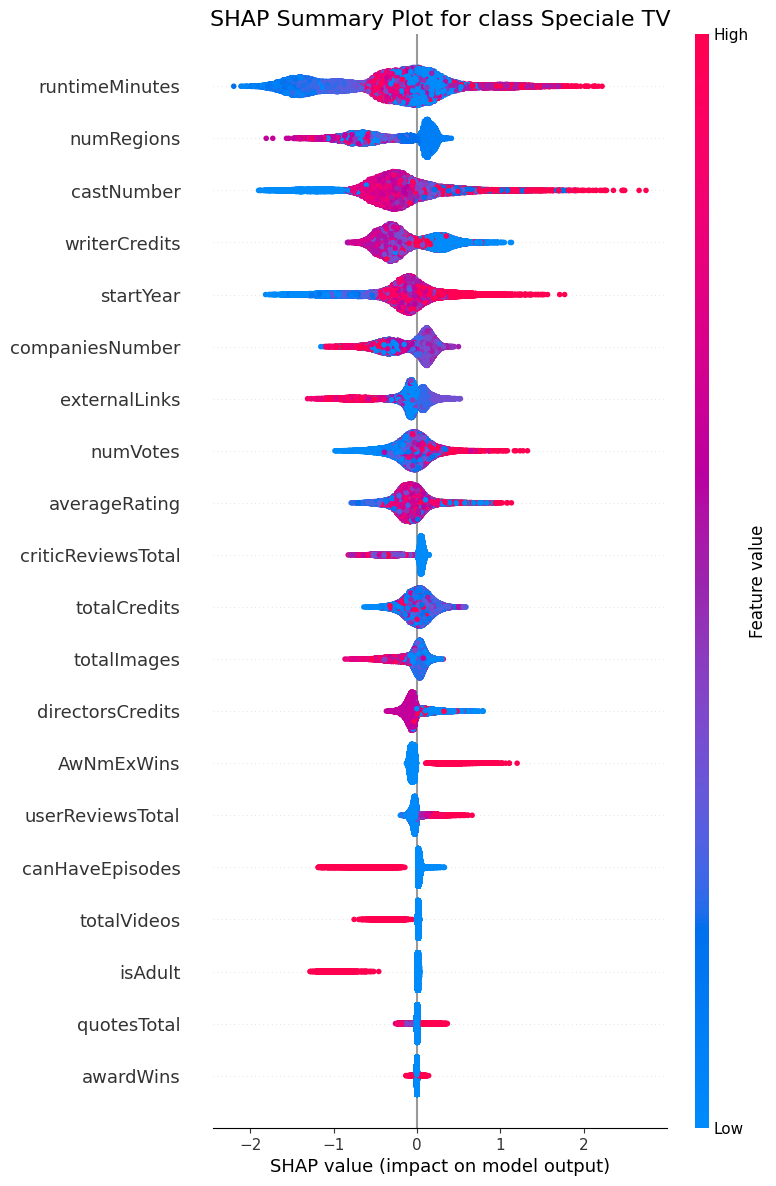

In [33]:
# Ora puoi usare il summary_plot per una classe specifica
classe_target = 3  # o quella che vuoi

shap.summary_plot(
    shap_vals_per_class[classe_target],
    X_test,
    plot_type="dot",  # o "dot"
    show=False,
    feature_names=features_name,
)

# Ridimensiona e mostra
fig = plt.gcf()
fig.set_size_inches(8, 12)
plt.title(f"SHAP Summary Plot for class {intervals[classe_target]}", fontsize=16)
plt.show()

In [35]:
# Questo codice serve a filtrare gli errori del modello XGBoost in base alla confidenza delle predizioni e alla classe reale.

# 2. Imposta soglia di probabilità
max_prob = 0.75  # include solo predizioni con confidenza <= 75%
min_prob = 0.0   # esclude predizioni con confidenza < 0%

# 3. Imposta classe reale da filtrare (es. '(8,9]') o None
target_class = 'Speciale TV'  # puoi mettere None per non filtrare

# 4. Predizioni e probabilità
y_pred_numeric = best_model.predict(X_test)
probs = best_model.predict_proba(X_test)

# 5. Converti predizioni e etichette vere in stringa leggibile
preds = [intervals[i] for i in y_pred_numeric]
true_labels = [intervals[i] for i in y_test]  # ATTENZIONE: serve y_test_numeric!

# 6. Costruisci DataFrame delle probabilità per ogni classe
probs_df = pd.DataFrame(probs, columns=intervals)

# 7. Aggiungi predizioni, etichette reali e confidenza della classe predetta
prob_pred_class = [
    row[pred] for row, pred in zip(probs_df.to_dict(orient="records"), preds)
]

results = probs_df.copy()
results["Classe_predetta"] = preds
results["Classe_reale"] = true_labels
results["Probabilità_predetta"] = prob_pred_class

# 8. Filtra solo gli errori
errori = results[results["Classe_predetta"] != results["Classe_reale"]]

# 9. Se richiesta, filtra solo per una classe reale specifica
if target_class is not None:
    errori = errori[errori["Classe_reale"] == target_class]

# 10. Filtra per soglia di probabilità
errori_filtrati = errori[
    (errori["Probabilità_predetta"] >= min_prob) &
    (errori["Probabilità_predetta"] <= max_prob)
]

# 11. Ordina per confidenza e seleziona i 10 peggiori errori "sicuri"
errori_top10 = errori_filtrati.sort_values(by="Probabilità_predetta", ascending=False).head(10)

# 12. Stampa risultato
if errori_top10.empty:
    print("⚠️  Nessun errore trovato con le condizioni specificate.")
else:
    print(f"🧪 I 10 errori più 'sicuri' (confidenza ≤ {max_prob*100:.0f}%)")
    if target_class:
        print(f"🎯 Classe reale selezionata: {target_class}")
    display(errori_top10)


🧪 I 10 errori più 'sicuri' (confidenza ≤ 75%)
🎯 Classe reale selezionata: Speciale TV


,Film,Serie TV,Shorts,Speciale TV,Video,Videogame,Classe_predetta,Classe_reale,Probabilità_predetta
39863,0.747431,0.009047,0.000329,0.183441,0.059606,0.000148,Film,Speciale TV,0.747431
33088,0.742586,0.065350,0.028019,0.063064,0.012293,0.088688,Film,Speciale TV,0.742586
41418,0.742334,0.001934,0.000077,0.248745,0.006779,0.000131,Film,Speciale TV,0.742334
11904,0.732095,0.062552,0.002289,0.200141,0.002826,0.000096,Film,Speciale TV,0.732095
26350,0.731712,0.024800,0.000400,0.124437,0.118537,0.000114,Film,Speciale TV,0.731712
20529,0.727639,0.016860,0.000482,0.079355,0.174997,0.000667,Film,Speciale TV,0.727639
13576,0.165240,0.051440,0.000321,0.057802,0.724489,0.000708,Video,Speciale TV,0.724489
24845,0.724156,0.100309,0.000969,0.109790,0.064713,0.000063,Film,Speciale TV,0.724156
39491,0.722161,0.015635,0.000259,0.076082,0.185304,0.000559,Film,Speciale TV,0.722161
23250,0.241063,0.721096,0.016815,0.016399,0.002340,0.002287,Serie TV,Speciale TV,0.721096


In [36]:
# 1. Scegli l'indice dell'istanza da spiegare
i2e = 39863  # Cambia questo con l’indice desiderato

In [37]:
# Estrai la riga come Series
record = X_test_df.iloc[i2e]

# Stampa i valori feature per feature
print(f"🎯 Valori delle feature per l'istanza {i2e}:\n")
for feature_name, value in record.items():
    print(f"{feature_name}: {value}")

🎯 Valori delle feature per l'istanza 39863:

startYear: 1.046282830132308
runtimeMinutes: 0.626542851642912
awardWins: -0.2570899128207565
numVotes: -0.5377701790338945
totalImages: -0.03276798666899005
totalVideos: -0.2539245481332793
totalCredits: -0.6850923894312004
criticReviewsTotal: -0.45491391316013896
AwNmExWins: -0.2699905793669116
canHaveEpisodes: -0.2741384978472973
isAdult: -0.13664722191564782
numRegions: -0.35450683947997164
userReviewsTotal: -0.5788057421186354
castNumber: -1.5671831284510283
companiesNumber: -0.675782474879348
averageRating: 0.7625227071846333
externalLinks: 0.24153612355956044
writerCredits: -0.2628912508618397
directorsCredits: 0.2521299918688377
quotesTotal: -0.3440812834309575


In [38]:
# 2. Istanza da spiegare (formato DataFrame e Series)
x_instance_df = X_test_df.iloc[[i2e]]   # DataFrame (1, n_features)
x_instance_series = X_test_df.iloc[i2e] # Series (n_features,)

# 3. Classe predetta dall’istanza
predicted_class_i2e = best_model.predict(x_instance_df)[0]
predicted_class_label = intervals[predicted_class_i2e]

print(f"✅ Classe predetta per l’istanza {i2e}: {predicted_class_label} (classe {predicted_class_i2e})")

# 4. Ottieni valori SHAP per la classe predetta
shap_values_instance = shap_vals_per_class[predicted_class_i2e][i2e]

# 5. FORCE PLOT (interattivo)
shap.initjs()
shap.force_plot(
    base_value=shap_explainer.expected_value[predicted_class_i2e],
    shap_values=shap_values_instance,
    features=x_instance_series,
    feature_names=features_name
)

✅ Classe predetta per l’istanza 39863: Film (classe 0)


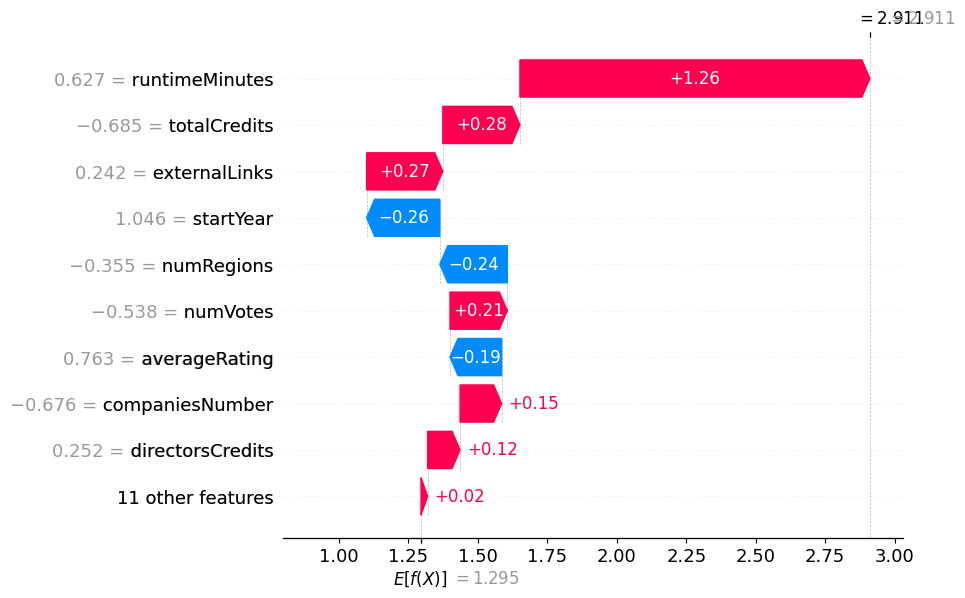

In [39]:
from shap.plots._waterfall import waterfall_legacy

shap.plots.waterfall(
    shap.Explanation(
        values=shap_values_instance,
        base_values=shap_explainer.expected_value[predicted_class_i2e],
        data=x_instance_series,
        feature_names=features_name
    )
)

In [40]:
#Questo codice serve a filtrare i record classificati correttamente da un modello XGBoost in base alla confidenza delle predizioni e alla classe reale.

# 2. Parametri di filtro
max_prob = 0.75    # massimo livello di confidenza
min_prob = 0.0     # minimo livello di confidenza (opzionale)
target_class = 'Speciale TV'   # o None per tutte

# 3. Predizioni e probabilità
y_pred_numeric = best_model.predict(X_test)
probs = best_model.predict_proba(X_test)

# 4. Conversione in etichette stringa leggibili
preds = [intervals[i] for i in y_pred_numeric]
true_labels = [intervals[i] for i in y_test]  # ⚠️ Serve y_test_numeric

# 5. Costruzione DataFrame
probs_df = pd.DataFrame(probs, columns=intervals)

# 6. Aggiunta colonne predizione, reale e probabilità associata alla predizione
prob_pred_class = [
    row[pred] for row, pred in zip(probs_df.to_dict(orient="records"), preds)
]

results = probs_df.copy()
results["Classe_predetta"] = preds
results["Classe_reale"] = true_labels
results["Probabilità_predetta"] = prob_pred_class

# 7. Filtra solo i record classificati correttamente
corretti = results[results["Classe_predetta"] == results["Classe_reale"]]

# 8. Filtro opzionale sulla classe reale
if target_class is not None:
    corretti = corretti[corretti["Classe_reale"] == target_class]

# 9. Filtro sul range di probabilità
corretti_filtrati = corretti[
    (corretti["Probabilità_predetta"] >= min_prob) &
    (corretti["Probabilità_predetta"] <= max_prob)
]

# 10. Ordina e seleziona i top 10
corretti_top10 = corretti_filtrati.sort_values(
    by="Probabilità_predetta", ascending=False
).head(10)

# 11. Mostra il risultato
if corretti_top10.empty:
    print("⚠️  Nessun record corretto trovato con le condizioni specificate.")
else:
    print(f"✅ I 10 record classificati correttamente con confidenza ≤ {max_prob*100:.0f}%")
    if target_class:
        print(f"🎯 Classe reale selezionata: {target_class}")
    display(corretti_top10)

✅ I 10 record classificati correttamente con confidenza ≤ 75%
🎯 Classe reale selezionata: Speciale TV


,Film,Serie TV,Shorts,Speciale TV,Video,Videogame,Classe_predetta,Classe_reale,Probabilità_predetta
21890,0.244289,0.006244,0.000212,0.747204,0.002006,0.000045,Speciale TV,Speciale TV,0.747204
7447,0.081521,0.077874,0.006694,0.740972,0.074273,0.018666,Speciale TV,Speciale TV,0.740972
12751,0.099778,0.121276,0.000187,0.716474,0.061622,0.000663,Speciale TV,Speciale TV,0.716474
7714,0.047466,0.075052,0.001614,0.704305,0.056132,0.115431,Speciale TV,Speciale TV,0.704305
2554,0.084062,0.065073,0.005386,0.686742,0.052855,0.105882,Speciale TV,Speciale TV,0.686742
17071,0.052905,0.044616,0.042346,0.669826,0.007945,0.182362,Speciale TV,Speciale TV,0.669826
27451,0.318416,0.005002,0.000081,0.667825,0.008247,0.000428,Speciale TV,Speciale TV,0.667825
9999,0.092574,0.093892,0.000364,0.664966,0.147816,0.000388,Speciale TV,Speciale TV,0.664966
38782,0.317942,0.008477,0.007754,0.660491,0.004062,0.001274,Speciale TV,Speciale TV,0.660491
9056,0.029532,0.110101,0.002254,0.629421,0.132444,0.096248,Speciale TV,Speciale TV,0.629421


In [41]:
# 1. Scegli l'indice dell'istanza da spiegare
i2e = 21890  # Cambia questo con l’indice desiderato
# Estrai la riga come Series
record = X_test_df.iloc[i2e]

In [42]:

# Stampa i valori feature per feature
print(f"🎯 Valori delle feature per l'istanza {i2e}:\n")
for feature_name, value in record.items():
    print(f"{feature_name}: {value}")

🎯 Valori delle feature per l'istanza 21890:

startYear: -0.7207325737062005
runtimeMinutes: 1.8413384590836623
awardWins: -0.2570899128207565
numVotes: -0.44667477449255266
totalImages: -1.0205929859412846
totalVideos: -0.2539245481332793
totalCredits: -0.5815155062738756
criticReviewsTotal: -0.45491391316013896
AwNmExWins: 1.5258902871647004
canHaveEpisodes: -0.2741384978472973
isAdult: -0.13664722191564782
numRegions: -0.35450683947997164
userReviewsTotal: 0.15681231434319193
castNumber: -0.9201830681955596
companiesNumber: 0.07805211507750806
averageRating: 0.4655505079561473
externalLinks: -0.8038377045195146
writerCredits: 1.1191338639762713
directorsCredits: 0.2521299918688377
quotesTotal: -0.3440812834309575


In [43]:
# 2. Istanza da spiegare (formato DataFrame e Series)
x_instance_df = X_test_df.iloc[[i2e]]   # DataFrame (1, n_features)
x_instance_series = X_test_df.iloc[i2e] # Series (n_features,)

# 3. Classe predetta dall’istanza
predicted_class_i2e = best_model.predict(x_instance_df)[0]
predicted_class_label = intervals[predicted_class_i2e]

print(f"✅ Classe predetta per l’istanza {i2e}: {predicted_class_label} (classe {predicted_class_i2e})")

# 4. Ottieni valori SHAP per la classe predetta
shap_values_instance = shap_vals_per_class[predicted_class_i2e][i2e]

# 5. FORCE PLOT (interattivo)
shap.initjs()
shap.force_plot(
    base_value=shap_explainer.expected_value[predicted_class_i2e],
    shap_values=shap_values_instance,
    features=x_instance_series,
    feature_names=features_name
)

✅ Classe predetta per l’istanza 21890: Speciale TV (classe 3)


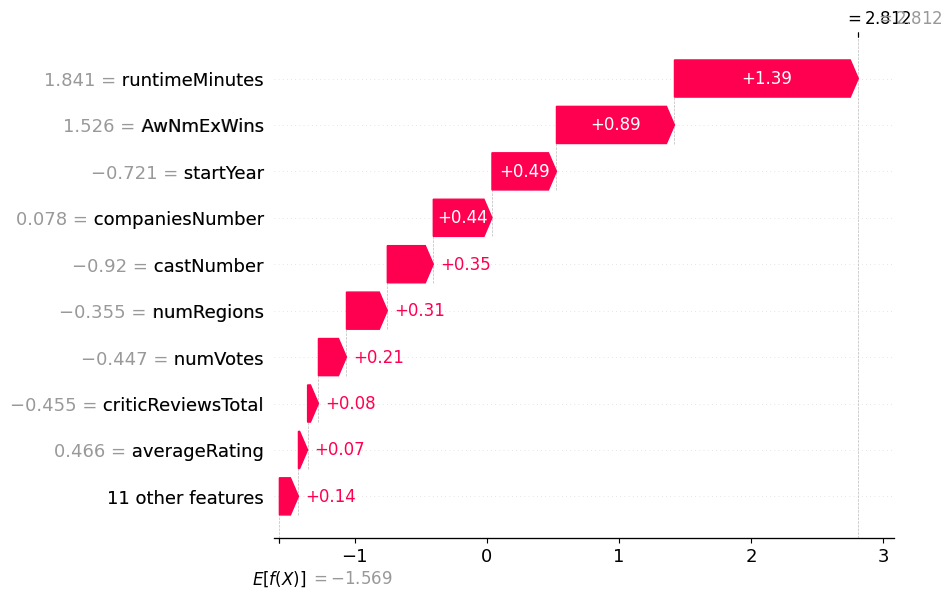

In [44]:
from shap.plots._waterfall import waterfall_legacy

# Waterfall plot (statico, utile anche se non sei in Jupyter)
shap.plots.waterfall(
    shap.Explanation(
        values=shap_values_instance,
        base_values=shap_explainer.expected_value[predicted_class_i2e],
        data=x_instance_series,
        feature_names=features_name
    )
)